# Lab 3 - Query Expansion

In [1]:
from helper_utils import load_chroma, word_wrap, project_embeddings
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction

In [2]:
embedding_function = SentenceTransformerEmbeddingFunction()

chroma_collection = load_chroma(filename='microsoft_annual_report_2022.pdf', collection_name='microsoft_annual_report_2022', embedding_function=embedding_function)
chroma_collection.count()

/Users/singh.akash/.pyenv/versions/3.11.4/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


349

In [3]:
import os
import openai
from openai import OpenAI

from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file
openai.api_key = os.environ['OPENAI_API_KEY']

openai_client = OpenAI()

In [5]:
import umap.umap_ as umap

embeddings = chroma_collection.get(include=['embeddings'])['embeddings']
umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit(embeddings)
projected_dataset_embeddings = project_embeddings(embeddings, umap_transform)

/Users/singh.akash/.pyenv/versions/3.11.4/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 349/349 [01:34<00:00,  3.70it/s]


### Use LLMs to augment and enhcance the query to vector search
- Expansion with generated answers: Use LLM to generate a hypothetical answer and add it to query
- we are kind of asking the model to hallucinate, but provbiding it a role, context and setting. Bounding the hallucination

## Expansion with generated answers
- https://arxiv.org/abs/2305.03653
- <img src="images/Lab3_QueryExpansionUsingGeneratedAnswer.png" width="400"> 

In [28]:
def augment_query_generated(query, model="gpt-3.5-turbo"):
    messages = [
        {
            "role": "system",
            ## we are kind of asking the model to hallucinate, but provbiding it a role, context and setting. Bounding the hallucination
            "content": "You are a helpful expert financial research assistant. Provide an example answer to the given question, that might be found in a document like an annual report. "
        },
        {"role": "user", "content": query}
    ] 

    response = openai_client.chat.completions.create(
        model=model,
        messages=messages,
        temperature=0
    )
    content = response.choices[0].message.content
    return content

In [29]:
original_query = "Was there significant turnover in the executive team?"
hypothetical_answer = augment_query_generated(original_query)

joint_query = f"{original_query} {hypothetical_answer}"
print(word_wrap(joint_query))

Was there significant turnover in the executive team? In the past
fiscal year, there was minimal turnover in the executive team. Only one
executive member, the Chief Financial Officer, retired after serving
the company for over 20 years. The position was filled by an internal
candidate who had been with the company for 15 years, ensuring a smooth
transition and continuity in leadership. The rest of the executive team
remains stable, with an average tenure of 10 years with the company.


In [30]:
results = chroma_collection.query(query_texts=joint_query, n_results=5, include=['documents', 'embeddings'])
retrieved_documents = results['documents'][0]

for doc in retrieved_documents:
    print(word_wrap(doc))
    print('')

the company engaged deloitte & touche llp, an independent registered
public accounting firm, to audit and render an opinion on the
consolidated financial statements and internal control over financial
reporting in accordance with the standards of the public company
accounting oversight board ( united states ). the board of directors,
through its audit committee, consisting solely of independent directors
of the company, meets periodically with management, internal auditors,
and our independent registered public accounting firm to ensure that
each is meeting its responsibilities and to discuss matters concerning
internal controls and financial reporting. deloitte & touche llp and
the internal auditors each have full and free access to the audit
committee. satya nadella chief executive officer amy e. hood executive
vice president and chief financial officer alice l. jolla corporate
vice president and chief accounting officer

88 report of independent registered public accounting firm to 

In [31]:
retrieved_embeddings = results['embeddings'][0]
original_query_embedding = embedding_function([original_query])
augmented_query_embedding = embedding_function([joint_query])

projected_original_query_embedding = project_embeddings(original_query_embedding, umap_transform)
projected_augmented_query_embedding = project_embeddings(augmented_query_embedding, umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.74it/s]


(-4.870594072341919,
 3.1981850147247313,
 1.4880938410758973,
 11.311221373081207)

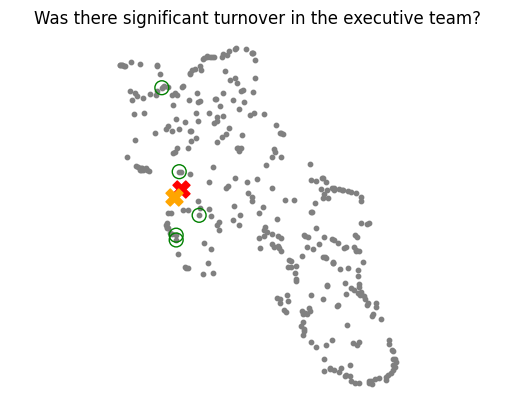

In [32]:
import matplotlib.pyplot as plt

# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')
plt.scatter(projected_original_query_embedding[:, 0], projected_original_query_embedding[:, 1], s=150, marker='X', color='r')
plt.scatter(projected_augmented_query_embedding[:, 0], projected_augmented_query_embedding[:, 1], s=150, marker='X', color='orange')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{original_query}')
plt.axis('off')

### Using the expanded query moves the query in the embedding space and hopefully results in better answers

## Expansion with multiple queries
- Ask LLM to generate more queries
- The queries should be related but different, coverring different aspects.
- PRompt engineering is important here
- ...
- <img src="images/Lab3_QueryExpansionUsingMultipleQueries.png" width="400">

In [33]:
def augment_multiple_query(query, model="gpt-3.5-turbo"):
    messages = [
        {
            "role": "system",
            "content": "You are a helpful expert financial research assistant. Your users are asking questions about an annual report. "
            "Suggest up to five additional related questions to help them find the information they need, for the provided question. "
            "Suggest only short questions without compound sentences. Suggest a variety of questions that cover different aspects of the topic."
            "Make sure they are complete questions, and that they are related to the original question."
            "Output one question per line. Do not number the questions."
        },
        {"role": "user", "content": query}
    ]

    response = openai_client.chat.completions.create(
        model=model,
        messages=messages,
    )
    content = response.choices[0].message.content
    content = content.split("\n")
    return content

In [34]:
original_query = "What were the most important factors that contributed to increases in revenue?"
augmented_queries = augment_multiple_query(original_query)

for query in augmented_queries:
    print(query)

- How did changes in pricing affect revenue growth?
- What impact did new product launches have on revenue?
- Were there any significant acquisitions that boosted revenue?
- Did changes in customer demographics or market trends influence revenue?
- How did currency exchange rates affect revenue growth?


In [35]:
queries = [original_query] + augmented_queries
results = chroma_collection.query(query_texts=queries, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents']

# Deduplicate the retrieved documents
unique_documents = set()
for documents in retrieved_documents:
    for document in documents:
        unique_documents.add(document)

for i, documents in enumerate(retrieved_documents):
    print(f"Query: {queries[i]}")
    print('')
    print("Results:")
    for doc in documents:
        print(word_wrap(doc))
        print('')
    print('-'*100)

Query: What were the most important factors that contributed to increases in revenue?

Results:
engineering, gaming, and linkedin. • sales and marketing expenses
increased $ 1. 7 billion or 8 % driven by investments in commercial
sales and linkedin. sales and marketing included a favorable foreign
currency impact of 2 %. • general and administrative expenses increased
$ 793 million or 16 % driven by investments in corporate functions.
operating income increased $ 13. 5 billion or 19 % driven by growth
across each of our segments. current year net income and diluted eps
were positively impacted by the net tax benefit related to the transfer
of intangible properties, which resulted in an increase to net income
and diluted eps of $ 3. 3 billion and $ 0. 44, respectively. prior year
net income and diluted eps were positively impacted by the net tax
benefit related to the india supreme court decision on withholding
taxes, which resulted in an increase to net income and diluted eps of $
620 

In [55]:
## flatten and claculate total results, 5 per query
len([d for doc in retrieved_documents for d in doc])

30

In [40]:
len(unique_documents)

19

In [36]:
original_query_embedding = embedding_function([original_query])
augmented_query_embeddings = embedding_function(augmented_queries)

project_original_query = project_embeddings(original_query_embedding, umap_transform)
project_augmented_queries = project_embeddings(augmented_query_embeddings, umap_transform)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.71it/s]


In [37]:
result_embeddings = results['embeddings']
result_embeddings = [item for sublist in result_embeddings for item in sublist]
projected_result_embeddings = project_embeddings(result_embeddings, umap_transform)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:07<00:00,  3.78it/s]


(-4.870594072341919,
 3.1981850147247313,
 1.4880938410758973,
 11.311221373081207)

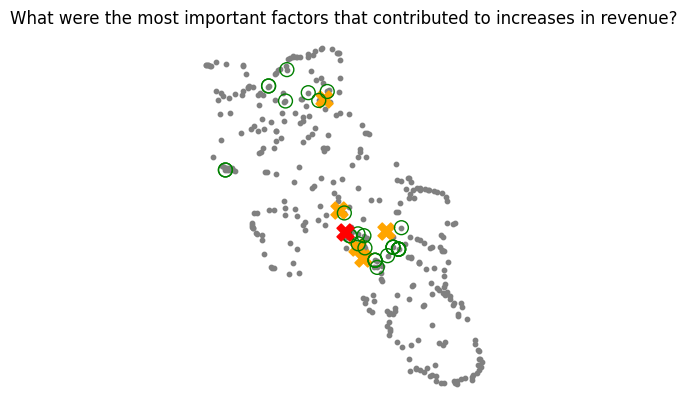

In [38]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(project_augmented_queries[:, 0], project_augmented_queries[:, 1], s=150, marker='X', color='orange')
plt.scatter(projected_result_embeddings[:, 0], projected_result_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')
plt.scatter(project_original_query[:, 0], project_original_query[:, 1], s=150, marker='X', color='r')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{original_query}')
plt.axis('off')

### So we can see that using augmented queries we can include other related info in dataset that the original query could nto reach
- For complex query we can include diverse info which can be useful for LLM
- However we have lot more results all of which may not be relevant